In [1]:
# packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from functools import reduce


# local
from nb_util import autoreload, add_dirs
autoreload()

add_dirs(['../'])
from nash_util import concordance_stats as cs
from nash_util import nash_definitions as nd
from nash_util import nash_changes as nc

In [2]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V03.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis')

In [89]:
df_list = []
for comp, df in c_dfs.items():
    df_temp = df.dropna(axis=0).copy()
    
    df_temp['CON_012'] = df_temp[['NP0','NP1','NP2']].apply(np.median,axis=1)
    df_temp['CON_A12'] = df_temp[['AIM','NP1','NP2']].apply(np.median,axis=1)
    df_temp['CON_0A2'] = df_temp[['NP0','AIM','NP2']].apply(np.median,axis=1)
    df_temp['CON_01A'] = df_temp[['NP0','NP1','AIM']].apply(np.median,axis=1)
    
    df_temp.drop(columns='PATHAI_ID',inplace=True)
    df_out = pd.melt(df_temp,
                     id_vars=['CASE_NAME','Visit'], 
                     value_vars=['AIM','NP0','NP1','NP2','CON_012','CON_A12','CON_0A2','CON_01A'],
                     var_name='SOURCE', 
                     value_name=comp, 
                     ignore_index=True).reset_index(drop=True)
    df_list.append(df_out)
c_df_tall = reduce(lambda x, y: pd.merge(x, y,how='inner',on=['CASE_NAME','Visit','SOURCE']).drop_duplicates(), df_list).reset_index(drop=True)



In [90]:
c_df_wide = c_df_tall.pivot(
    index=['CASE_NAME','SOURCE'],
    columns=['Visit'],
    values=['Fibrosis','Inflammation','Ballooning','Steatosis'],
)
c_df_wide.columns.set_names(['NASH Component','Visit'], inplace=True)



In [91]:
c_df_wide

NASH Component    Fibrosis          Inflammation          Ballooning           \
Visit             Baseline Month-12     Baseline Month-12   Baseline Month-12   
CASE_NAME SOURCE                                                                
101-0380  AIM          2.0      1.0          1.0      0.0        1.0      0.0   
          CON_012      3.0      1.0          1.0      0.0        1.0      0.0   
          CON_01A      2.0      1.0          1.0      0.0        1.0      0.0   
          CON_0A2      2.0      1.0          1.0      0.0        1.0      0.0   
          CON_A12      3.0      1.0          1.0      0.0        1.0      0.0   
...                    ...      ...          ...      ...        ...      ...   
184-0865  CON_0A2      3.0      3.0          1.0      1.0        2.0      2.0   
          CON_A12      3.0      3.0          2.0      1.0        2.0      2.0   
          NP0          3.0      2.0          1.0      1.0        2.0      2.0   
          NP1          3.0      3.0          2.0      2.0        2.0      2.0   
          NP2          3.0      3.0          2.0      1.0        2.0      2.0   

NASH Component    Steatosis           
Visit              Baseline Month-12  
CASE_NAME SOURCE                      
101-0380  AIM           1.0      0.0  
          CON_012       1.0      0.0  
          CON_01A       1.0      0.0  
          CON_0A2       1.0      0.0  
          CON_A12       1.0      0.0  
...                     ...      ...  
184-0865  CON_0A2       1.0      1.0  
          CON_A12       1.0      1.0  
          NP0           1.0      1.0  
          NP1           1.0      1.0  
          NP2           1.0      2.0  

[2608 rows x 8 columns]

In [92]:
visits = ['Baseline', 'Month-12']
nash_delta_df = c_df_wide.copy()
nash_delta_df['Fibrosis Reduction'] = c_df_wide.apply(lambda r: nc.A_FIB_REDUCTION(r, visits), axis=1)
nash_delta_df['NAS 2pt Reduction'] = c_df_wide.apply(lambda r: nc.B_NAS_2P_REDUCTION(r, visits), axis=1)
nash_delta_df['NASH Resolution with Stable Fibrosis'] = c_df_wide.apply(lambda r: nc.C_NASH_RES_STABLE_FIB_PEP(r, visits), axis=1)
nash_delta_df['Fibrosis Reduction with Stable NASH'] = c_df_wide.apply(lambda r: nc.D_FIB_RED_STABLE_NASH_PEP(r, visits), axis=1)
nash_delta_df['NASH Resolution and Fibrosis Reduction'] = c_df_wide.apply(lambda r: nc.E_FIB_RED_NASH_RES_PEP(r, visits), axis=1)
nash_delta_df.columns = nash_delta_df.columns.get_level_values('NASH Component')
nash_delta_df = nash_delta_df.reset_index()



In [161]:
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import balanced_accuracy_score, accuracy_score, cohen_kappa_score
from sklearn.utils import resample

def pick_col_level(df):
    col_levels = [i[1] if i[1] else i[0] for i in df.columns.to_flat_index()]
    df.columns = col_levels

def get_ci(x):
    cis = np.percentile(x,[2.5,97.5])
    return pd.Series({
        'lci':cis[0],
        'uci':cis[1]
    })

def get_binary_aggrement_stats(a,b):
    
    pls = np.sort(np.unique(a))
    
    pl_ppv, pl_tpr, pl_f1, pl_n = prfs(a, b)
    ppv, tpr, f1, _ = prfs(a, b, average='weighted')
    acc = accuracy_score(a, b)
    bal_acc = balanced_accuracy_score(a, b)
    kappa = cohen_kappa_score(a, b)
    
    avg_stats = pd.DataFrame({
        'PPV':ppv,
        'TPR':tpr,
        'F1':f1,
        'Accuracy':acc,
        'Balanced Accuracy':bal_acc,
        'Kappa':kappa
    },index=[0])
    
    pl_stats = pd.DataFrame({
        'Labels':pls,
        'PPV':pl_ppv,
        'TPR':pl_tpr,
        'F1':pl_f1,
        'N':pl_n
    })
    
    return avg_stats, pl_stats

def get_agg_stats(a,b,stratify=None):
    if stratify is not None:
        a, b, stratify = cs.clean_nans([a, b, stratify])
        a = a.astype(str)
        b = b.astype(str)
        strat_str = stratify.astype(str)
    else:
        a, b = cs.clean_nans([a, b])
        a = a.astype(str)
        b = b.astype(str)
        
    avg_stats, pl_stats = get_binary_aggrement_stats(a, b)

    avg_l = []
    pl_l = []

    for ii in range(10000):
        a_bs, b_bs = resample(a, b, stratify=stratify)
        avg_bs, pl_bs = get_binary_aggrement_stats(a_bs, b_bs)

        avg_l.append(avg_bs)

        pl_t = pl_bs.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value')
        pl_l.append(pl_t)

    pldf = pd.concat(pl_l)
    avgdf = pd.concat(avg_l)

    t = avgdf.apply(lambda x: np.percentile(x,[2.5,97.5]))
    t = pd.concat([avg_stats,t])
    t.index = ['pe','lci','uci']
    t = t.T
    t.index.name = 'Score'
    t = t.reset_index()

    q = pldf.groupby(['Labels','Stat']).apply(get_ci).reset_index()
    q = pl_stats.melt(id_vars = ['Labels'],var_name='Stat',value_name='pe').merge(q,how='left',on=['Labels','Stat']).drop_duplicates()
    
    return t, q


def ret_scores(df):
    av_stats = []
    pl_stats = []

    a, b = get_binary_aggrement_stats(df['CON_A12'],df['NP0'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    a, b = get_binary_aggrement_stats(df['CON_0A2'],df['NP1'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    a, b = get_binary_aggrement_stats(df['CON_01A'],df['NP2'])
    av_stats.append(a)
    pl_stats.append(b.melt(id_vars = ['Labels'],var_name='Stat',value_name='Value'))

    pldf = pd.concat(pl_stats)
    avgdf = pd.concat(av_stats)

    t = avgdf.apply(np.mean, axis=0)
    t = t.T
    t.index.name = 'Score'
    t = t.reset_index()

    q = pldf.groupby(['Labels','Stat']).apply(np.mean).reset_index()

    return t, q
        
        
def get_avg_agg_stats_spec(dfi):
    
    df = dfi.copy()
    df = df.dropna()
    df = df.astype(str)
    df = df.reset_index(drop=True)
    
    av_mean, pl_mean = ret_scores(df)
    av_mean.columns = ['Stat','pe']
    pl_mean.columns = ['Labels','Stat','pe']

    av_l = []
    pl_l = []
    for ii in range(10000):
        ridx = resample(df.index, stratify=df['CON_012'])
        av_bs, pl_bs = ret_scores(df.loc[ridx,:])        
        av_l.append(av_bs)
        pl_l.append(pl_bs)
    
    av_ci = pd.concat(av_l)
    av_ci.columns = ['Stat','Value']
    
    av_out = av_ci.groupby(['Stat']).apply(get_ci).reset_index()
    av_out = av_mean.merge(av_out, how='left',on=['Stat']).drop_duplicates()
    
    pl_ci = pd.concat(pl_l)
    pl_out = pl_ci.groupby(['Labels','Stat']).apply(get_ci).reset_index()
    pl_out = pl_mean.merge(pl_out,how='left',on=['Labels','Stat']).drop_duplicates()
        
    return av_out, pl_out

In [166]:
end_points = ['Fibrosis Reduction',
              'NAS 2pt Reduction',
              'NASH Resolution with Stable Fibrosis',
              'Fibrosis Reduction with Stable NASH',
              'NASH Resolution and Fibrosis Reduction']

av_list = []
pl_list = []

for ep in end_points:

    a = nash_delta_df.reset_index().pivot(
        index=['CASE_NAME'],
        columns=['SOURCE'],
        values=[ep]
    )
    a = a.reset_index()
    pick_col_level(a)
    a.dropna(inplace=True)

    av_gloo, pl_gloo = get_avg_agg_stats_spec(a)
    av_gloo['Kind'] = 'GLOO'
    pl_gloo['Kind'] = 'GLOO'
    av_gloo['End Point'] = ep
    pl_gloo['End Point'] = ep


    av_aim, pl_aim = get_agg_stats(a['CON_012'],a['AIM'],stratify=a['CON_012'])
    av_aim['Kind'] = 'AIM'
    pl_aim['Kind'] = 'AIM'
    av_aim['End Point'] = ep
    pl_aim['End Point'] = ep

    av_list.append(pd.concat([av_aim,av_gloo]))
    pl_list.append(pd.concat([pl_aim,pl_gloo]))

av_all = pd.concat(av_list)
pl_all = pd.concat(pl_list)


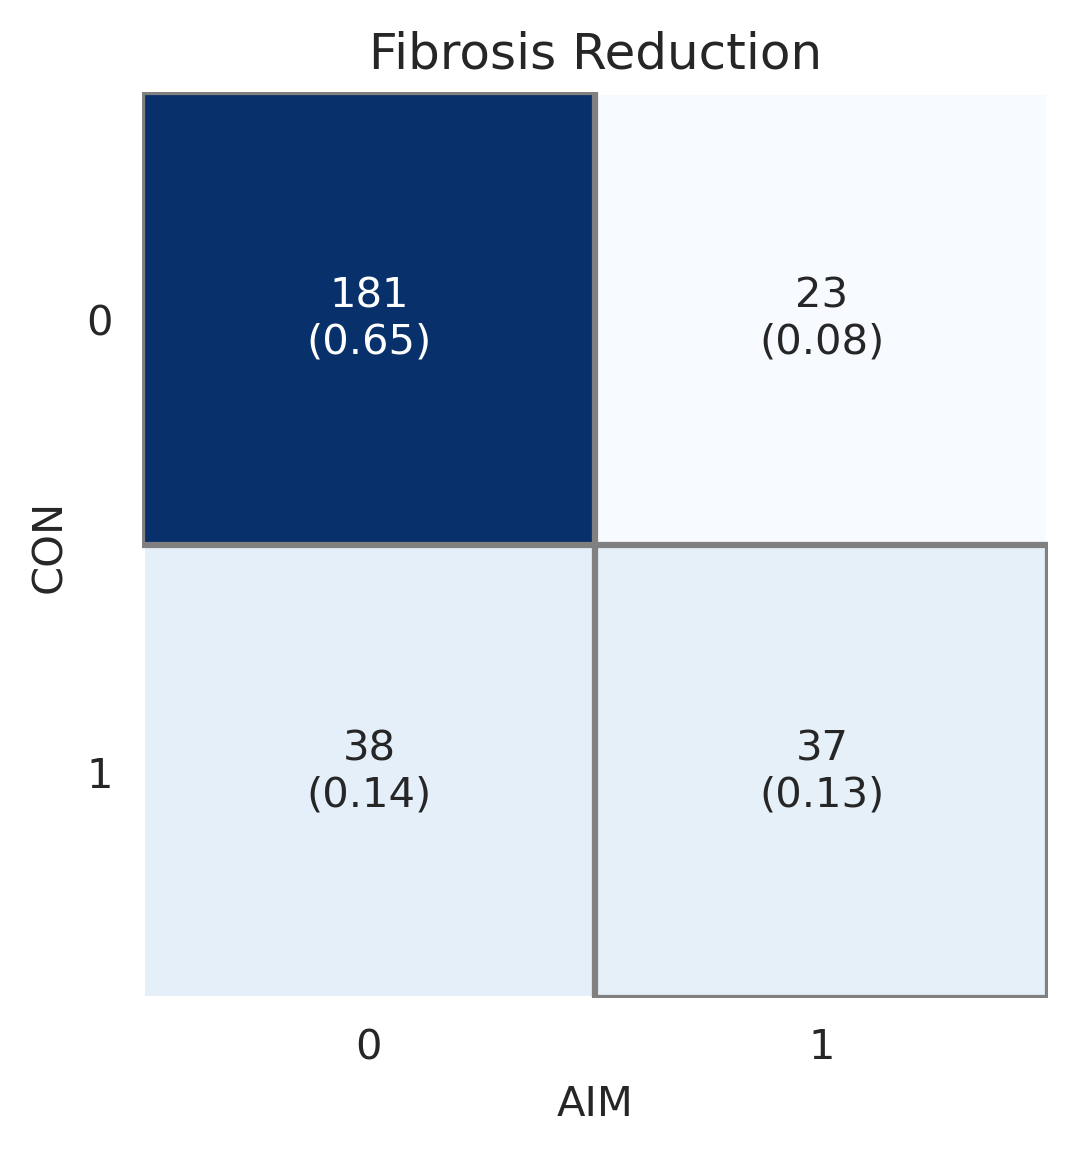

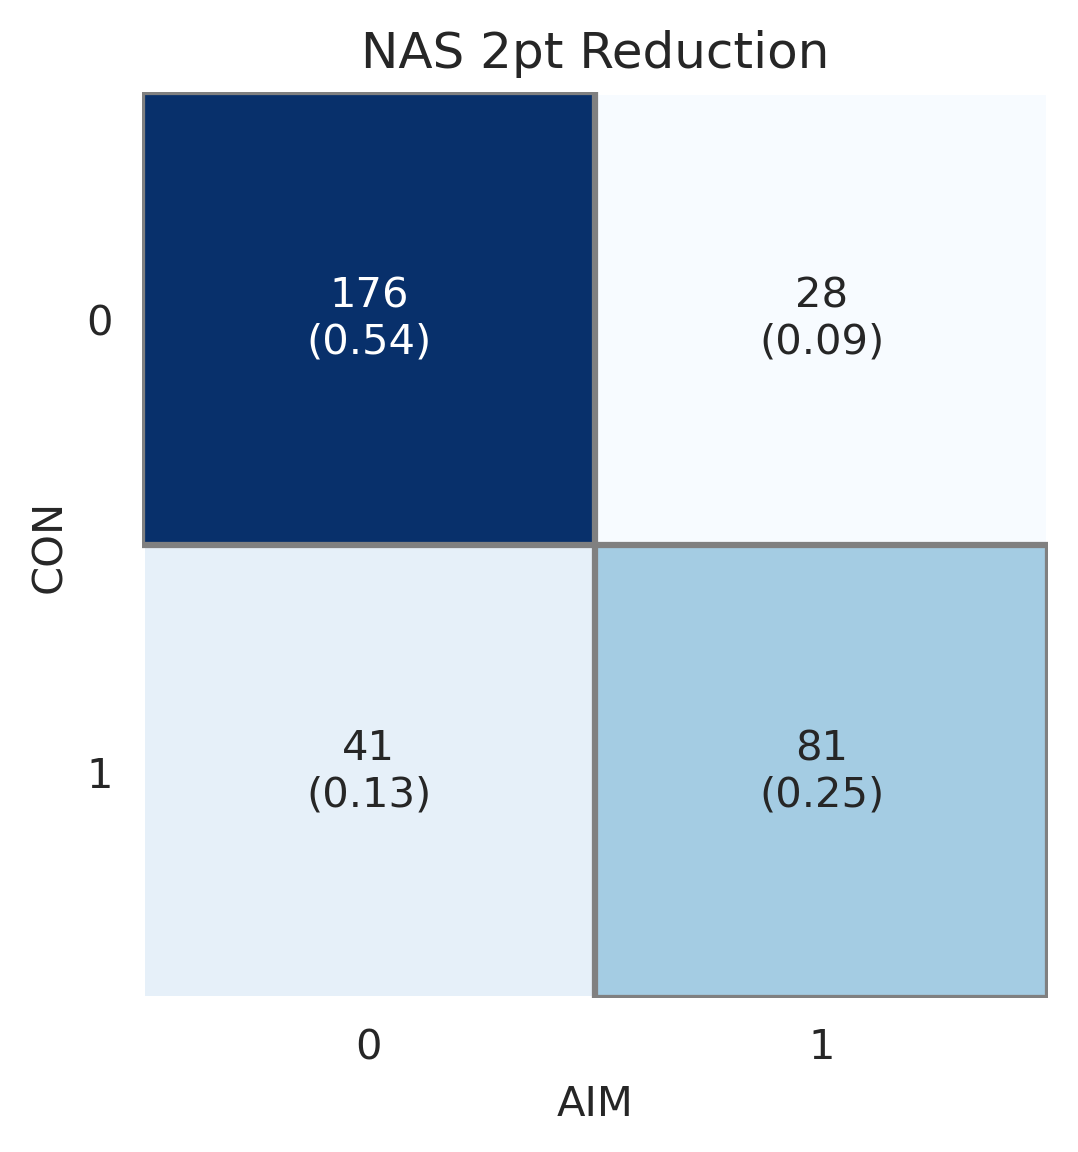

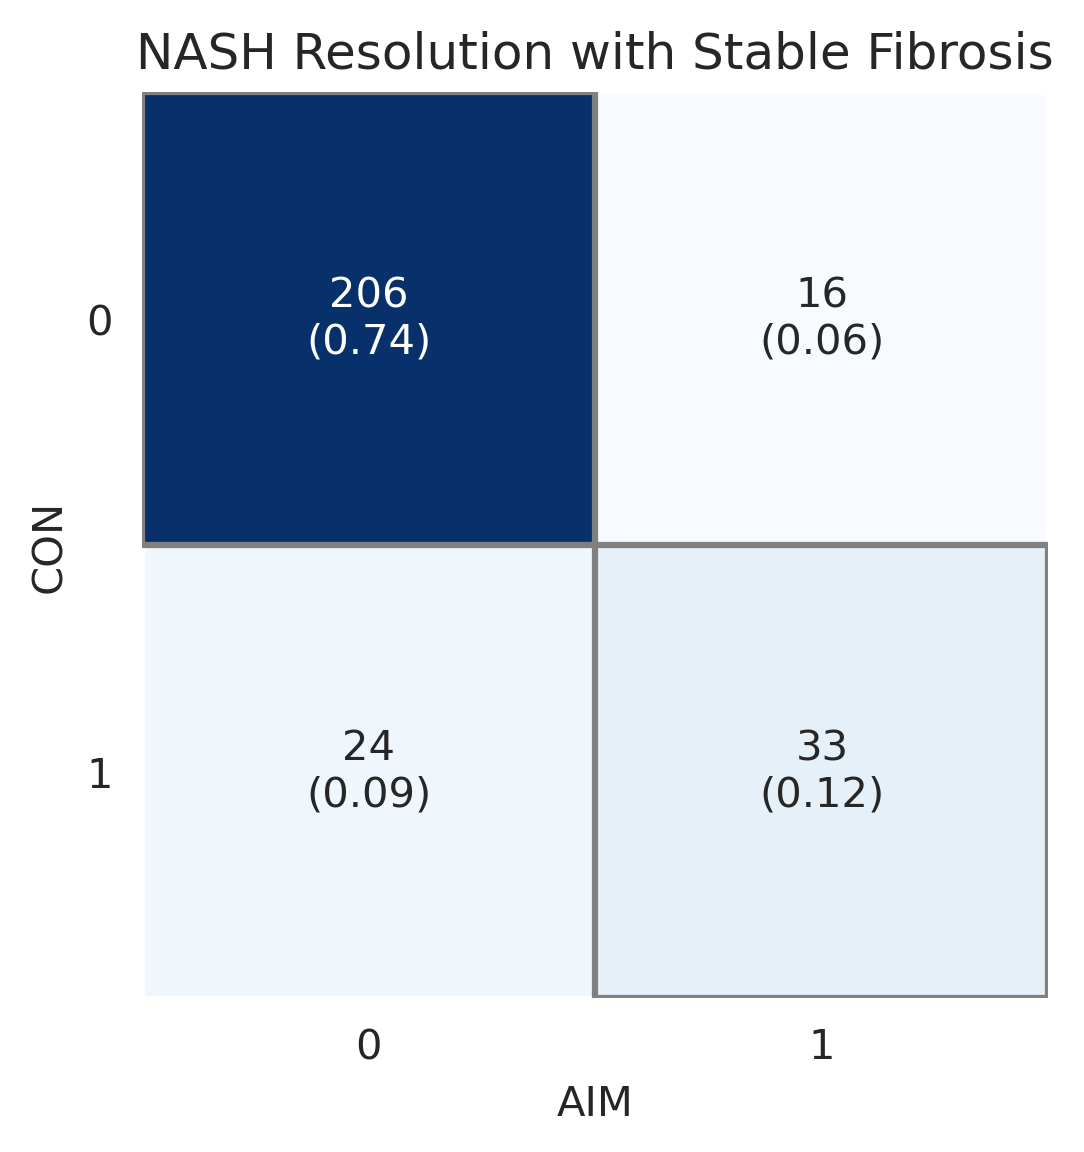

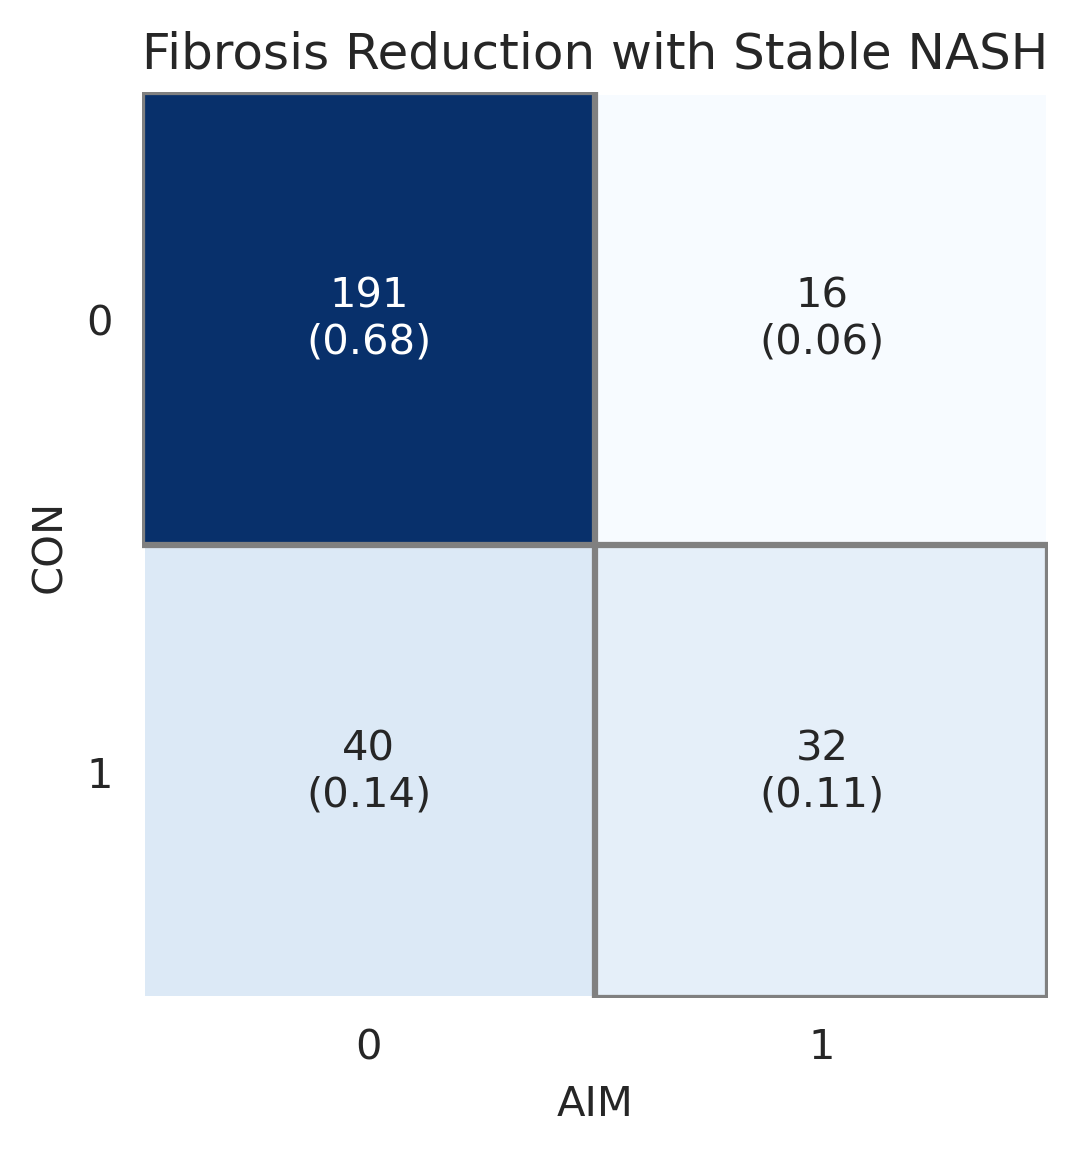

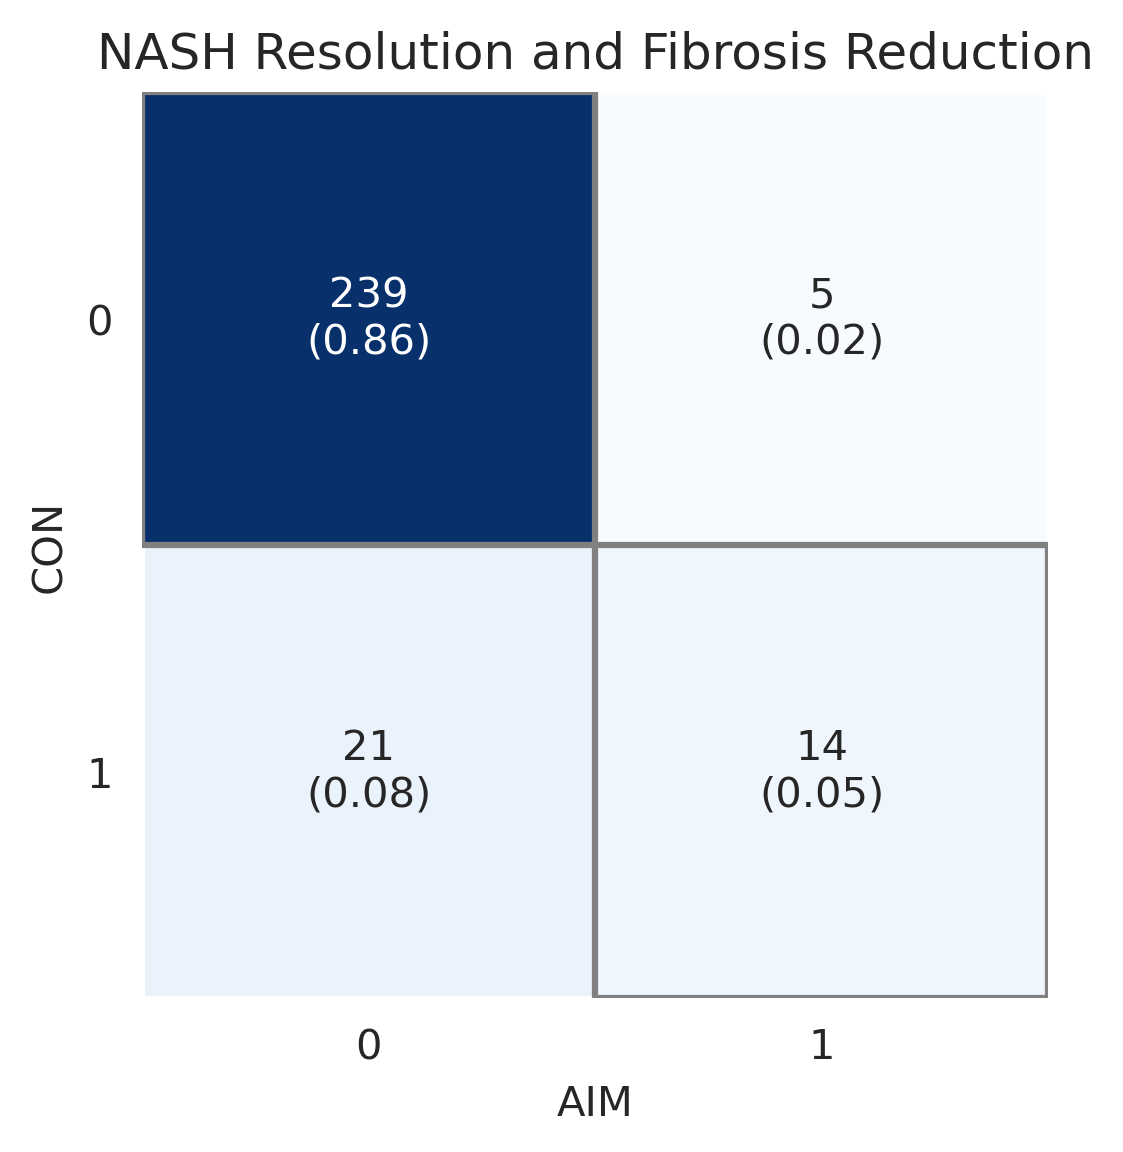

In [165]:
es_list = []
pw_list = []

def pick_col_level(df):
    col_levels = [i[1] if i[1] else i[0] for i in df.columns.to_flat_index()]
    df.columns = col_levels
    
for ep in ['Fibrosis Reduction','NAS 2pt Reduction','NASH Resolution with Stable Fibrosis','Fibrosis Reduction with Stable NASH','NASH Resolution and Fibrosis Reduction']:
    a = nash_delta_df.reset_index().pivot(
        index=['CASE_NAME'],
        columns=['SOURCE'],
        values=[ep]
    )
    a = a.reset_index()
    pick_col_level(a)
    a.dropna(inplace=True)
    
    
    _ = cs.plot_confusion_table(a['CON_012'],a['AIM'],name_a='CON',name_b='AIM',title=ep, norm='all')
    plt.show()


In [66]:
pairwise_stats

,AIM PW AVG,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,Change Measure,Metric
0,"0.74 (0.7, 0.78)","0.75 (0.71, 0.79)","0.72 (0.67, 0.78)","0.74 (0.68, 0.79)","0.79 (0.74, 0.84)",279,Fibrosis Reduction,Agreement Rate
0,"0.78 (0.75, 0.81)","0.73 (0.7, 0.77)","0.71 (0.66, 0.76)","0.71 (0.66, 0.76)","0.77 (0.73, 0.82)",326,NAS 2pt Reduction,Agreement Rate
0,"0.84 (0.8, 0.86)","0.8 (0.76, 0.84)","0.8 (0.76, 0.85)","0.81 (0.76, 0.86)","0.78 (0.73, 0.83)",279,NASH Resolution with Stable Fibrosis,Agreement Rate
0,"0.77 (0.73, 0.81)","0.77 (0.73, 0.8)","0.74 (0.68, 0.79)","0.75 (0.7, 0.8)","0.81 (0.76, 0.85)",279,Fibrosis Reduction with Stable NASH,Agreement Rate
0,"0.89 (0.86, 0.92)","0.85 (0.82, 0.88)","0.81 (0.76, 0.86)","0.87 (0.83, 0.91)","0.87 (0.83, 0.91)",279,NASH Resolution and Fibrosis Reduction,Agreement Rate


In [64]:
es_leg_stats

,Value,N,Change Measure,Metric
0,"0.78 (0.73, 0.83)",279,Fibrosis Reduction,Agreement Rate
0,"0.79 (0.74, 0.83)",326,NAS 2pt Reduction,Agreement Rate
0,"0.86 (0.81, 0.9)",279,NASH Resolution with Stable Fibrosis,Agreement Rate
0,"0.8 (0.75, 0.85)",279,Fibrosis Reduction with Stable NASH,Agreement Rate
0,"0.91 (0.87, 0.94)",279,NASH Resolution and Fibrosis Reduction,Agreement Rate


In [182]:
def fix_score(row):
    if row['Score']!=row['Score']:
        return row['Stat']
    else:
        return row['Score']

av_test = av_all.copy()
av_test['Score'] = av_test.apply(fix_score,axis=1)
av_test.drop(columns='Stat',inplace=True)

In [183]:
av_test

,Score,pe,lci,uci,Kind,End Point
0,PPV,0.770082,0.721415,0.817502,AIM,Fibrosis Reduction
1,TPR,0.781362,0.738351,0.824373,AIM,Fibrosis Reduction
2,F1,0.773092,0.726314,0.818354,AIM,Fibrosis Reduction
3,Accuracy,0.781362,0.738351,0.824373,AIM,Fibrosis Reduction
4,Balanced Accuracy,0.690294,0.628235,0.750294,AIM,Fibrosis Reduction
5,Kappa,0.406279,0.282923,0.526439,AIM,Fibrosis Reduction
0,PPV,0.801440,0.771410,0.832574,GLOO,Fibrosis Reduction
1,TPR,0.782557,0.749104,0.813620,GLOO,Fibrosis Reduction
2,F1,0.787001,0.755446,0.817088,GLOO,Fibrosis Reduction
3,Accuracy,0.782557,0.749104,0.813620,GLOO,Fibrosis Reduction


In [184]:
pl_all.to_csv('temp_pl_all.csv')